In [5]:
import udma
import numpy as np
import fxpmath as fx
import matplotlib.pyplot as plt
from tqdm import trange

In [6]:
cb = udma.UDMA_CLASS('192.168.1.10', 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [7]:
cb.write_reg(0, 1)
cb.write_reg(0, 0)

[(1, 0), 0]

In [8]:
for i in trange(1):
    x = np.random.randint(0,32767)
    cb.write_fifo(1, [x])
    #print(x)
    while (cb.read_reg(1)[1][0] & 1 == 0):
        pass

100%|██████████| 1/1 [00:00<00:00, 24.44it/s]


In [9]:
# AGENTS
class Agent:
    def __init__(self, n_anctions, alfa):
        self.alfa = alfa
        self.n_anctions = n_anctions
        self.indices = np.arange(n_anctions)
        self.prob = np.ones(self.n_anctions) / self.n_anctions
        #self.prob = fx.Fxp(np.ones(self.n_anctions) / self.n_anctions, signed=True, n_word=25, n_frac=22)
    def step(self, action, reward):    
        self.prob = (1 - self.alfa * reward) * self.prob
        self.prob[action] += self.alfa * reward
    def act(self):
        #aux0 = np.array(self.prob)
        #aux1 = np.sum(aux0)
        #p_aux = aux0/aux1
        return np.random.choice(self.indices, p=self.prob)

In [10]:
# QUANTUM
def general1qgate(a,b,c):
    u2 = np.matrix([[             np.cos(a/2), -np.exp(1j*c)    *np.sin(a/2)],
                    [np.exp(1j*b)*np.sin(a/2),  np.exp(1j*(b+c))*np.cos(a/2)]])
    return u2

def Numpy_QGT_Nplayers(tipo, J_init, J_dg):
    n_p = len(tipo)
    strategies_gate = 1
    for i in range(n_p):      
      players_gate = general1qgate(tipo[i][0], tipo[i][1], tipo[i][2])
      strategies_gate = np.kron(strategies_gate, players_gate)
    outputstate = J_dg * strategies_gate * J_init
    prob = np.power(np.abs(outputstate),2)
    return prob

def matrix_reward(rotat, J_init, J_dg):  
  prob = Numpy_QGT_Nplayers(rotat, J_init, J_dg)
  reward_g = prob.transpose() * game
  reward_h = reward_g.tolist()[0]
  return reward_h

# GAME
def int_to_binary(s,m):
    if s == 0:
        return "0 " * m
    binary1 = ""
    while s > 0:
        binary1 = str(s % 2) + " " + binary1
        s = s // 2
    binary2 = "0 " * (m - len(binary1)//2) + binary1
    return binary2

def platonia_matrix(n): 
  mm = np.zeros([2**n,n])
  for i in range(n):
    mm[2**i][n-i-1] = 10
  return  mm

def minority_matrix(n):
  mm = np.zeros([2**n,n])
  for i in range(2**n):
    numpy_data = np.fromstring(int_to_binary(i,n), dtype=int, sep=' ')
    if (np.count_nonzero(numpy_data == 0) > np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 1, 10, 0)
    elif (np.count_nonzero(numpy_data == 0) < np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 0, 10, 0)
  return  mm

In [11]:
# MAIN
players     = 2
alfa        = 1/(2**11)
t_max       = 100000
window1     = 1000
actions     = [0 for i in range(players)]
rotat       = np.zeros([len(actions), 3])
rewards     = np.zeros((players, t_max))
rewards_avg = np.zeros(rewards.shape)
game        = platonia_matrix(players)

N_SIZE = 3
A_MAX  = 2 * np.pi
angulos = np.arange(0, A_MAX, A_MAX / np.power(2, N_SIZE))
all_actions = [(rx,ry,0) for rx in angulos for ry in angulos]
#all_actions = [(rx,ry,rz) for rx in angulos for ry in angulos for rz in angulos]
gamma = np.pi/2
print("Players = {}. Learning Rate = {}. Gamma = {:.6f}. Number of actions = {}. \n {}".format(players, alfa, gamma, len(all_actions), game))

init_mat = np.matrix([[1] if i==0 else [0] for i in range(2**players)])
I_f = np.array(np.eye(2**players))
X_f = np.array(np.flip(np.eye(2**players),0))
J = np.matrix(np.cos(gamma/2) * I_f + 1j * np.sin(gamma/2) * X_f)
J_dg = J.H
J_init = J * init_mat

Players = 2. Learning Rate = 0.00048828125. Gamma = 1.570796. Number of actions = 64. 
 [[ 0.  0.]
 [ 0. 10.]
 [10.  0.]
 [ 0.  0.]]


In [12]:
# Initialization
agents = []
hw_data = []                            # extra
for i in range(players-1):
    agents.append(Agent(n_anctions=len(all_actions), alfa=alfa))
    actions[i] = agents[i].act()
    rotat[i] = all_actions[actions[i]]
##############################
i = players-1
cb.write_reg(0, 1)
cb.write_reg(0, 0)
actions[i] = cb.read_reg(0)[1][0]       #np.random.randint(0, 512)
rotat[i] = all_actions[actions[i]]
##############################
reward = matrix_reward(rotat, J_init, J_dg)
print(reward)

[0.0, 5.000000000000002]


In [13]:
# Iterations
for t in trange(t_max):
    # Update
    for i in range(players-1):
        rewards[i,t] = reward[i]
        if t<window1:
            rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
        else:
            rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])
        agents[i].step(actions[i], reward[i])
        actions[i] = agents[i].act()
        rotat[i] = all_actions[actions[i]]    
    ##############################
    i = players-1
    rewards[i,t] = reward[i]
    if t<window1:
        rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
    else:
        rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])    
    
    r_bin = fx.Fxp(reward[i], signed=True, n_word=16, n_frac=11)
    r_int = int(r_bin.bin(), 2)
    cb.write_fifo(1, [r_int])
    while(cb.read_reg(1)[1][0] & 1 == 0):
        pass
    actions[i] = cb.read_reg(0)[1][0]
    rotat[i] = all_actions[actions[i]]
    ##############################
    reward = matrix_reward(rotat, J_init, J_dg)
    if (t % 1000) == 0:
        print("R_SW = {} | R_HW = {}".format(rewards_avg[0,t], rewards_avg[1,t]))

  0%|          | 2/100000 [00:00<2:17:18, 12.14it/s]

R_SW = 0.0 | R_HW = 5.000000000000002


  1%|          | 1002/100000 [01:23<2:19:03, 11.87it/s]

R_SW = 2.4748582496848415 | R_HW = 2.5045557346130636


  2%|▏         | 2002/100000 [02:47<2:15:58, 12.01it/s]

R_SW = 2.4828420137735048 | R_HW = 2.621979571512403


  3%|▎         | 3002/100000 [04:11<2:18:30, 11.67it/s]

R_SW = 2.464225484168156 | R_HW = 2.639739093748852


  4%|▍         | 4002/100000 [05:35<2:14:07, 11.93it/s]

R_SW = 2.8640535147471504 | R_HW = 2.4182986927182912


  5%|▌         | 5002/100000 [06:59<2:13:04, 11.90it/s]

R_SW = 2.8714052900066305 | R_HW = 2.7269481960167057


  6%|▌         | 6002/100000 [08:23<2:12:48, 11.80it/s]

R_SW = 3.2247113001111756 | R_HW = 3.26854940662625


  7%|▋         | 7002/100000 [09:47<2:12:55, 11.66it/s]

R_SW = 3.8686993464208306 | R_HW = 3.8017903356768947


  8%|▊         | 8002/100000 [11:11<2:07:50, 11.99it/s]

R_SW = 3.934268247458324 | R_HW = 4.517394626274068


  9%|▉         | 9002/100000 [12:35<2:06:44, 11.97it/s]

R_SW = 4.47785417057423 | R_HW = 4.421247087105589


 10%|█         | 10002/100000 [13:59<2:07:18, 11.78it/s]

R_SW = 4.588821846660835 | R_HW = 4.596543832405183


 11%|█         | 11002/100000 [15:23<2:03:30, 12.01it/s]

R_SW = 4.817170292856811 | R_HW = 4.695809331037222


 12%|█▏        | 12002/100000 [16:48<2:01:55, 12.03it/s]

R_SW = 4.841110818425309 | R_HW = 4.811949504156456


 13%|█▎        | 13002/100000 [18:12<2:04:30, 11.65it/s]

R_SW = 4.78547917599798 | R_HW = 4.932130774624369


 14%|█▍        | 14002/100000 [19:36<1:59:42, 11.97it/s]

R_SW = 5.008724185058399 | R_HW = 4.724727787917866


 15%|█▌        | 15002/100000 [20:59<1:57:54, 12.01it/s]

R_SW = 5.104505973454133 | R_HW = 4.746341230875487


 16%|█▌        | 16002/100000 [22:23<1:56:56, 11.97it/s]

R_SW = 4.924382795772914 | R_HW = 4.995152034223392


 17%|█▋        | 17002/100000 [23:47<1:55:54, 11.93it/s]

R_SW = 5.20615315335014 | R_HW = 4.741178735374716


 18%|█▊        | 18002/100000 [25:11<1:54:40, 11.92it/s]

R_SW = 4.898643203994294 | R_HW = 5.049796703746286


 19%|█▉        | 19002/100000 [26:35<1:52:41, 11.98it/s]

R_SW = 5.0112361487998855 | R_HW = 4.958040786289616


 20%|██        | 20002/100000 [27:59<1:52:38, 11.84it/s]

R_SW = 5.111527992579835 | R_HW = 4.857142946787588


 21%|██        | 21002/100000 [29:23<1:51:10, 11.84it/s]

R_SW = 4.80729795137358 | R_HW = 5.171259025555425


 22%|██▏       | 22002/100000 [30:47<1:49:45, 11.84it/s]

R_SW = 4.924382795772915 | R_HW = 5.075617204227087


 23%|██▎       | 23002/100000 [32:11<1:47:27, 11.94it/s]

R_SW = 5.031135260077725 | R_HW = 4.963869734927273


 24%|██▍       | 24002/100000 [33:35<1:45:39, 11.99it/s]

R_SW = 4.945513901558627 | R_HW = 5.044496088451366


 25%|██▌       | 25002/100000 [34:59<1:44:47, 11.93it/s]

R_SW = 4.408913237763825 | R_HW = 5.526402708947937


 26%|██▌       | 26002/100000 [36:22<1:44:14, 11.83it/s]

R_SW = 4.872691972812325 | R_HW = 5.100264003399598


 27%|██▋       | 27002/100000 [37:46<1:43:11, 11.79it/s]

R_SW = 5.362144169123232 | R_HW = 4.629328823977736


 28%|██▊       | 28002/100000 [39:10<1:40:30, 11.94it/s]

R_SW = 5.330141900144748 | R_HW = 4.664863094860249


 29%|██▉       | 29002/100000 [40:34<1:38:07, 12.06it/s]

R_SW = 4.31875213620691 | R_HW = 5.672469845247233


 30%|███       | 30002/100000 [41:58<1:36:13, 12.12it/s]

R_SW = 4.467916463740417 | R_HW = 5.523305517713727


 31%|███       | 31002/100000 [43:22<1:36:29, 11.92it/s]

R_SW = 5.611581419480584 | R_HW = 4.388418580519418


 32%|███▏      | 32002/100000 [44:46<1:34:07, 12.04it/s]

R_SW = 5.504652993469411 | R_HW = 4.490352001535586


 33%|███▎      | 33002/100000 [46:10<1:34:23, 11.83it/s]

R_SW = 4.524114412704365 | R_HW = 5.455905567315618


 34%|███▍      | 34002/100000 [47:34<1:32:27, 11.90it/s]

R_SW = 4.344238103899829 | R_HW = 5.639062866377357


 35%|███▌      | 35002/100000 [48:57<1:30:21, 11.99it/s]

R_SW = 5.577300676500928 | R_HW = 4.381380252876487


 36%|███▌      | 36002/100000 [50:21<1:29:24, 11.93it/s]

R_SW = 5.377935287370547 | R_HW = 4.606828685997615


 37%|███▋      | 37002/100000 [51:45<1:27:50, 11.95it/s]

R_SW = 4.392045635427629 | R_HW = 5.575664324142466


 38%|███▊      | 38002/100000 [53:09<1:27:40, 11.79it/s]

R_SW = 4.842959258410768 | R_HW = 5.152651732316305


 39%|███▉      | 39002/100000 [54:33<1:24:02, 12.10it/s]

R_SW = 4.9552607372184445 | R_HW = 5.033286249700571


 40%|████      | 40002/100000 [55:57<1:23:41, 11.95it/s]

R_SW = 5.506067704892665 | R_HW = 4.4889372901123314


 41%|████      | 41002/100000 [57:21<1:24:13, 11.67it/s]

R_SW = 3.896889548078827 | R_HW = 6.103110451921175


 42%|████▏     | 42002/100000 [58:45<1:20:25, 12.02it/s]

R_SW = 5.316648810738676 | R_HW = 4.65277516356922


 43%|████▎     | 43002/100000 [1:00:09<1:20:02, 11.87it/s]

R_SW = 5.093133869075327 | R_HW = 4.902477121651746


 44%|████▍     | 44002/100000 [1:01:33<1:18:22, 11.91it/s]

R_SW = 4.966619779402864 | R_HW = 5.033380220597138


 45%|████▌     | 45002/100000 [1:02:57<1:16:03, 12.05it/s]

R_SW = 4.344582004335607 | R_HW = 5.653954992573419


 46%|████▌     | 46002/100000 [1:04:20<1:14:48, 12.03it/s]

R_SW = 5.943940887988043 | R_HW = 4.019025078233872


 47%|████▋     | 47002/100000 [1:05:44<1:15:01, 11.77it/s]

R_SW = 4.703545012859921 | R_HW = 5.296454987140081


 48%|████▊     | 48002/100000 [1:07:08<1:11:59, 12.04it/s]

R_SW = 4.24353145251378 | R_HW = 5.750010539400241


 49%|████▉     | 49002/100000 [1:08:33<1:11:26, 11.90it/s]

R_SW = 4.979326320386706 | R_HW = 4.991413617793771


 50%|█████     | 50002/100000 [1:09:57<1:09:46, 11.94it/s]

R_SW = 5.856287290460492 | R_HW = 4.104964661023623


 51%|█████     | 51002/100000 [1:11:20<1:07:55, 12.02it/s]

R_SW = 4.104129635273356 | R_HW = 5.870038332382721


 52%|█████▏    | 52002/100000 [1:12:45<1:07:22, 11.87it/s]

R_SW = 6.376739239493849 | R_HW = 3.6217977574151763


 53%|█████▎    | 53002/100000 [1:14:09<1:06:20, 11.81it/s]

R_SW = 5.042316810224516 | R_HW = 4.9312451617094855


 54%|█████▍    | 54002/100000 [1:15:33<1:04:09, 11.95it/s]

R_SW = 4.334341616582738 | R_HW = 5.655668373427254


 55%|█████▌    | 55002/100000 [1:16:57<1:01:42, 12.15it/s]

R_SW = 4.962771717443409 | R_HW = 5.00700724093974


 56%|█████▌    | 56002/100000 [1:18:21<1:01:31, 11.92it/s]

R_SW = 5.767834978763624 | R_HW = 4.2307020181454025


 57%|█████▋    | 57002/100000 [1:19:45<1:00:10, 11.91it/s]

R_SW = 4.552106802319033 | R_HW = 5.383919112543233


 58%|█████▊    | 58002/100000 [1:21:09<58:52, 11.89it/s]  

R_SW = 5.149480387588933 | R_HW = 4.7633884894645355


 59%|█████▉    | 59002/100000 [1:22:33<57:13, 11.94it/s]  

R_SW = 5.578887021200089 | R_HW = 4.3797939081773265


 60%|██████    | 60002/100000 [1:23:57<57:33, 11.58it/s]

R_SW = 3.2514789530292862 | R_HW = 6.739137032702781


 61%|██████    | 61002/100000 [1:25:21<54:11, 11.99it/s]

R_SW = 4.932119559703228 | R_HW = 5.02378240271063


 62%|██████▏   | 62002/100000 [1:26:45<53:05, 11.93it/s]

R_SW = 5.823958959894724 | R_HW = 4.141076005140244


 63%|██████▎   | 63002/100000 [1:28:09<51:38, 11.94it/s]

R_SW = 7.257146711775693 | R_HW = 2.7428532882243095


 64%|██████▍   | 64002/100000 [1:29:33<50:55, 11.78it/s]

R_SW = 6.591938813661513 | R_HW = 3.3670970997911533


 65%|██████▌   | 65002/100000 [1:30:57<49:02, 11.89it/s]

R_SW = 5.30358359113309 | R_HW = 4.374806740498953


 66%|██████▌   | 66002/100000 [1:32:21<46:54, 12.08it/s]

R_SW = 3.9895422933715246 | R_HW = 5.128058897912921


 67%|██████▋   | 67002/100000 [1:33:45<47:06, 11.67it/s]

R_SW = 3.4492525869224373 | R_HW = 5.624562484061148


 68%|██████▊   | 68002/100000 [1:35:09<44:08, 12.08it/s]

R_SW = 3.438158252463195 | R_HW = 5.89168235944124


 69%|██████▉   | 69002/100000 [1:36:33<43:06, 11.98it/s]

R_SW = 3.4903967779462772 | R_HW = 5.800046722930227


 70%|███████   | 70002/100000 [1:37:57<42:11, 11.85it/s]

R_SW = 2.918603131265863 | R_HW = 6.069249741425373


 71%|███████   | 71002/100000 [1:39:21<41:12, 11.73it/s]

R_SW = 2.8463619703001632 | R_HW = 5.926429448017558


 72%|███████▏  | 72002/100000 [1:40:45<38:56, 11.98it/s]

R_SW = 3.2575839555949284 | R_HW = 5.54522055948279


 73%|███████▎  | 73002/100000 [1:42:09<38:04, 11.82it/s]

R_SW = 3.0115290554843326 | R_HW = 6.066778997200609


 74%|███████▍  | 74002/100000 [1:43:33<35:54, 12.07it/s]

R_SW = 2.947350720036231 | R_HW = 6.422094947752992


 75%|███████▌  | 75002/100000 [1:44:57<34:41, 12.01it/s]

R_SW = 3.2083564877661206 | R_HW = 5.929224723498344


 76%|███████▌  | 76002/100000 [1:46:20<33:12, 12.04it/s]

R_SW = 2.35103361579149 | R_HW = 6.439564851264772


 77%|███████▋  | 77002/100000 [1:47:45<32:23, 11.83it/s]

R_SW = 2.310461273124005 | R_HW = 6.321024841091093


 78%|███████▊  | 78002/100000 [1:49:09<30:24, 12.06it/s]

R_SW = 2.0861486993989518 | R_HW = 6.5508344431048


 79%|███████▉  | 79002/100000 [1:50:33<29:11, 11.99it/s]

R_SW = 1.693447425539721 | R_HW = 6.929407709347916


 80%|████████  | 80002/100000 [1:51:57<28:08, 11.84it/s]

R_SW = 1.4733337550792327 | R_HW = 7.146950357701702


 81%|████████  | 81002/100000 [1:53:21<26:18, 12.04it/s]

R_SW = 1.3702933971549556 | R_HW = 7.253522717530009


 82%|████████▏ | 82002/100000 [1:54:45<25:14, 11.88it/s]

R_SW = 1.4434676975376308 | R_HW = 7.341633741229977


 83%|████████▎ | 83002/100000 [1:56:09<24:27, 11.58it/s]

R_SW = 1.6002563453724261 | R_HW = 7.320298385133901


 84%|████████▍ | 84002/100000 [1:57:32<22:18, 11.95it/s]

R_SW = 1.9719557138158483 | R_HW = 7.045157220694913


 85%|████████▌ | 85002/100000 [1:58:56<21:03, 11.87it/s]

R_SW = 2.0179820179820185 | R_HW = 6.915990751989919


 86%|████████▌ | 86002/100000 [2:00:21<19:53, 11.73it/s]

R_SW = 1.5871628371628377 | R_HW = 7.097242399974231


 87%|████████▋ | 87002/100000 [2:01:44<18:13, 11.89it/s]

R_SW = 1.4016161508021645 | R_HW = 7.177097879709359


 88%|████████▊ | 88002/100000 [2:03:08<16:50, 11.87it/s]

R_SW = 1.3828848820708959 | R_HW = 7.199967146066733


 89%|████████▉ | 89002/100000 [2:04:32<15:31, 11.81it/s]

R_SW = 1.3256565764705635 | R_HW = 7.222940384852534


 90%|█████████ | 90002/100000 [2:05:56<14:00, 11.89it/s]

R_SW = 1.267911021166968 | R_HW = 7.259346889513561


 91%|█████████ | 91002/100000 [2:07:20<12:39, 11.84it/s]

R_SW = 1.2633077600518139 | R_HW = 7.246039129461748


 92%|█████████▏| 92002/100000 [2:08:44<10:59, 12.13it/s]

R_SW = 1.249482750296737 | R_HW = 7.256332137312796


 93%|█████████▎| 93002/100000 [2:10:08<09:49, 11.88it/s]

R_SW = 1.2610245093965364 | R_HW = 7.251854382021054


 94%|█████████▍| 94002/100000 [2:11:32<08:19, 12.00it/s]

R_SW = 1.268088513204594 | R_HW = 7.248322380117026


 95%|█████████▌| 95002/100000 [2:12:56<07:00, 11.87it/s]

R_SW = 1.2560295044015313 | R_HW = 7.268908395819121


 96%|█████████▌| 96002/100000 [2:14:20<05:34, 11.93it/s]

R_SW = 1.2642535134395272 | R_HW = 7.243024377260982


 97%|█████████▋| 97002/100000 [2:15:44<04:12, 11.87it/s]

R_SW = 1.2524975024975027 | R_HW = 7.279504401531208


 98%|█████████▊| 98002/100000 [2:17:08<02:46, 12.03it/s]

R_SW = 1.2494827502967374 | R_HW = 7.282519153731974


 99%|█████████▉| 99002/100000 [2:18:31<01:24, 11.87it/s]

R_SW = 1.2521945046364649 | R_HW = 7.258009392245998


100%|██████████| 100000/100000 [2:19:55<00:00, 11.91it/s]


Average Reward of Player 0 = 1.256672.
Average Reward of Player 1 = 7.268413.
Performance over all players = 85.25%.


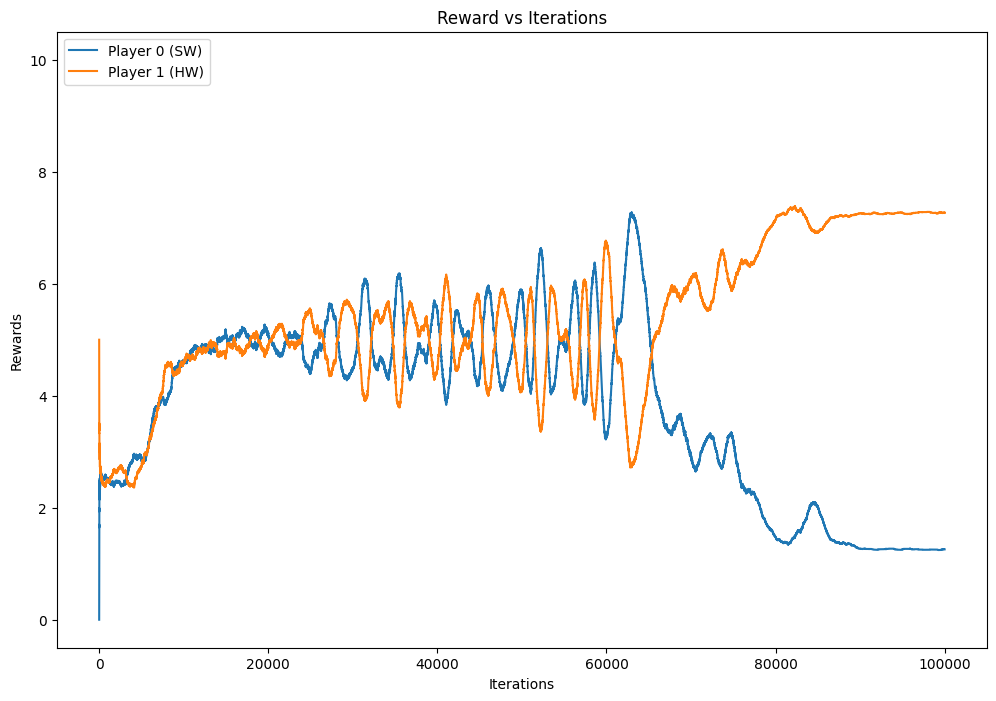

In [14]:
# Plotting
plt.figure(figsize=(12,8))
cumsum = 0
for i in range(players):
    if i!=(players-1):
        plt.plot(rewards_avg[i], label="Player {} (SW)".format(i))
    else:
        plt.plot(rewards_avg[i], label="Player {} (HW)".format(i))
    print("Average Reward of Player {} = {:.6f}.".format(i, rewards_avg[i][-1]))
    cumsum += rewards_avg[i][-1]
print("Performance over all players = {:.2f}%.".format(10 * cumsum / (players // 2)))
plt.ylim(-0.5,10.5)
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.title("Reward vs Iterations")
plt.legend(loc="upper left")
plt.show()